# IPEO Project - Inference notebook
This notebook demonstrates inference on a test image using the trained ResNet34 model with data augmentation.

In [33]:
import os
import torch
import torchvision.transforms as T
from torchvision.models import resnet34
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## 1. Load the test image

Found 8 images in 'test_sample' folder
Successfully loaded 8 images


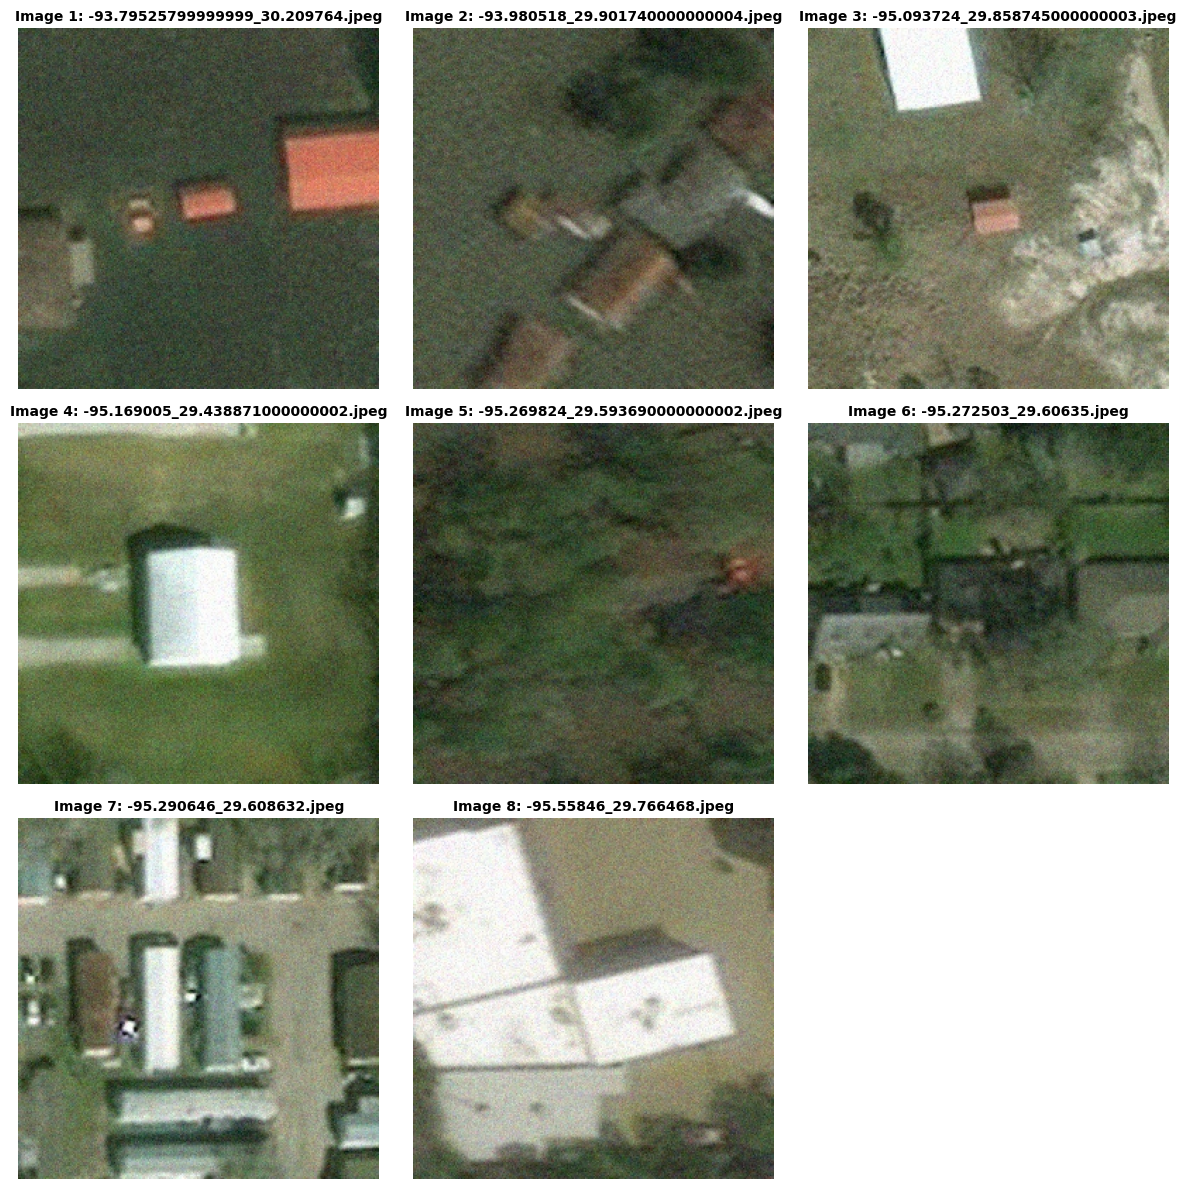

In [34]:
#get all images from test_sample folder
test_folder = "test_sample"
test_image_paths = [os.path.join(test_folder, f) for f in os.listdir(test_folder) 
                    if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
test_image_paths.sort()

print(f"Found {len(test_image_paths)} images in '{test_folder}' folder")

#load images
images = []
for path in test_image_paths:
    try:
        images.append(Image.open(path).convert('RGB'))
    except Exception as e:
        print(f"Error loading {path}: {e}")

print(f"Successfully loaded {len(images)} images")

#display the test images
num_images = len(images)
if num_images == 0:
    print("No images found!")
else:
    #calculate grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.ravel() if num_images > 1 else [axes]
    
    for idx, (image, path) in enumerate(zip(images, test_image_paths)):
        axes[idx].imshow(image)
        axes[idx].set_title(f"Image {idx+1}: {os.path.basename(path)}", fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    
    #hide extra subplots if grid is larger than number of images
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

## 2. Load the trained model

In [35]:
#Define device, check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Load the model 
model = resnet34(num_classes=2)

#Load trained weights
model_path = "models/resnet_final.pth"  
model.load_state_dict(torch.load(model_path, map_location=device))

#Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

print("Model loaded successfully!")

Using device: cpu
Model loaded successfully!


/var/folders/4h/p7pm5jv5159ftt0l8h_6772r0000gn/T/ipykernel_6731/1316871390.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

## 3. Run inference

In [36]:
#do the same preprocessing as during training
#normalization values computed from training set (compute using data_utils.py)
mean = [0.3520651161670685, 0.38347339630126953, 0.2852245569229126]
std = [0.14353740215301514, 0.12388759851455688, 0.12524263560771942]
normalize = T.Normalize(mean, std)

#define transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])

#class names
classes = ['damage', 'no_damage']

#process all images and store results
results = []

for idx, image in enumerate(images):
    #preprocess the image
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    #run inference
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        prediction = output.argmax(1).item()
    
    results.append({
        'image': image,
        'prediction': prediction,
        'probabilities': probabilities
    })
    
    print(f"Image {idx+1}")
    print(f"Prediction: {classes[prediction]}")
    print(f"Confidence: {probabilities[0][prediction].item()*100:.2f}%")
    print(f"Probabilities:")
    print(f"- Damage: {probabilities[0][0].item()*100:.2f}%")
    print(f"- No damage: {probabilities[0][1].item()*100:.2f}%")

Image 1
Prediction: damage
Confidence: 99.96%
Probabilities:
- Damage: 99.96%
- No damage: 0.04%
Image 2
Prediction: damage
Confidence: 100.00%
Probabilities:
- Damage: 100.00%
- No damage: 0.00%
Image 3
Prediction: no_damage
Confidence: 95.49%
Probabilities:
- Damage: 4.51%
- No damage: 95.49%
Image 4
Prediction: no_damage
Confidence: 99.17%
Probabilities:
- Damage: 0.83%
- No damage: 99.17%
Image 5
Prediction: damage
Confidence: 99.92%
Probabilities:
- Damage: 99.92%
- No damage: 0.08%
Image 6
Prediction: no_damage
Confidence: 99.99%
Probabilities:
- Damage: 0.01%
- No damage: 99.99%
Image 7
Prediction: no_damage
Confidence: 100.00%
Probabilities:
- Damage: 0.00%
- No damage: 100.00%
Image 8
Prediction: damage
Confidence: 100.00%
Probabilities:
- Damage: 100.00%
- No damage: 0.00%


## 4. Display predictions

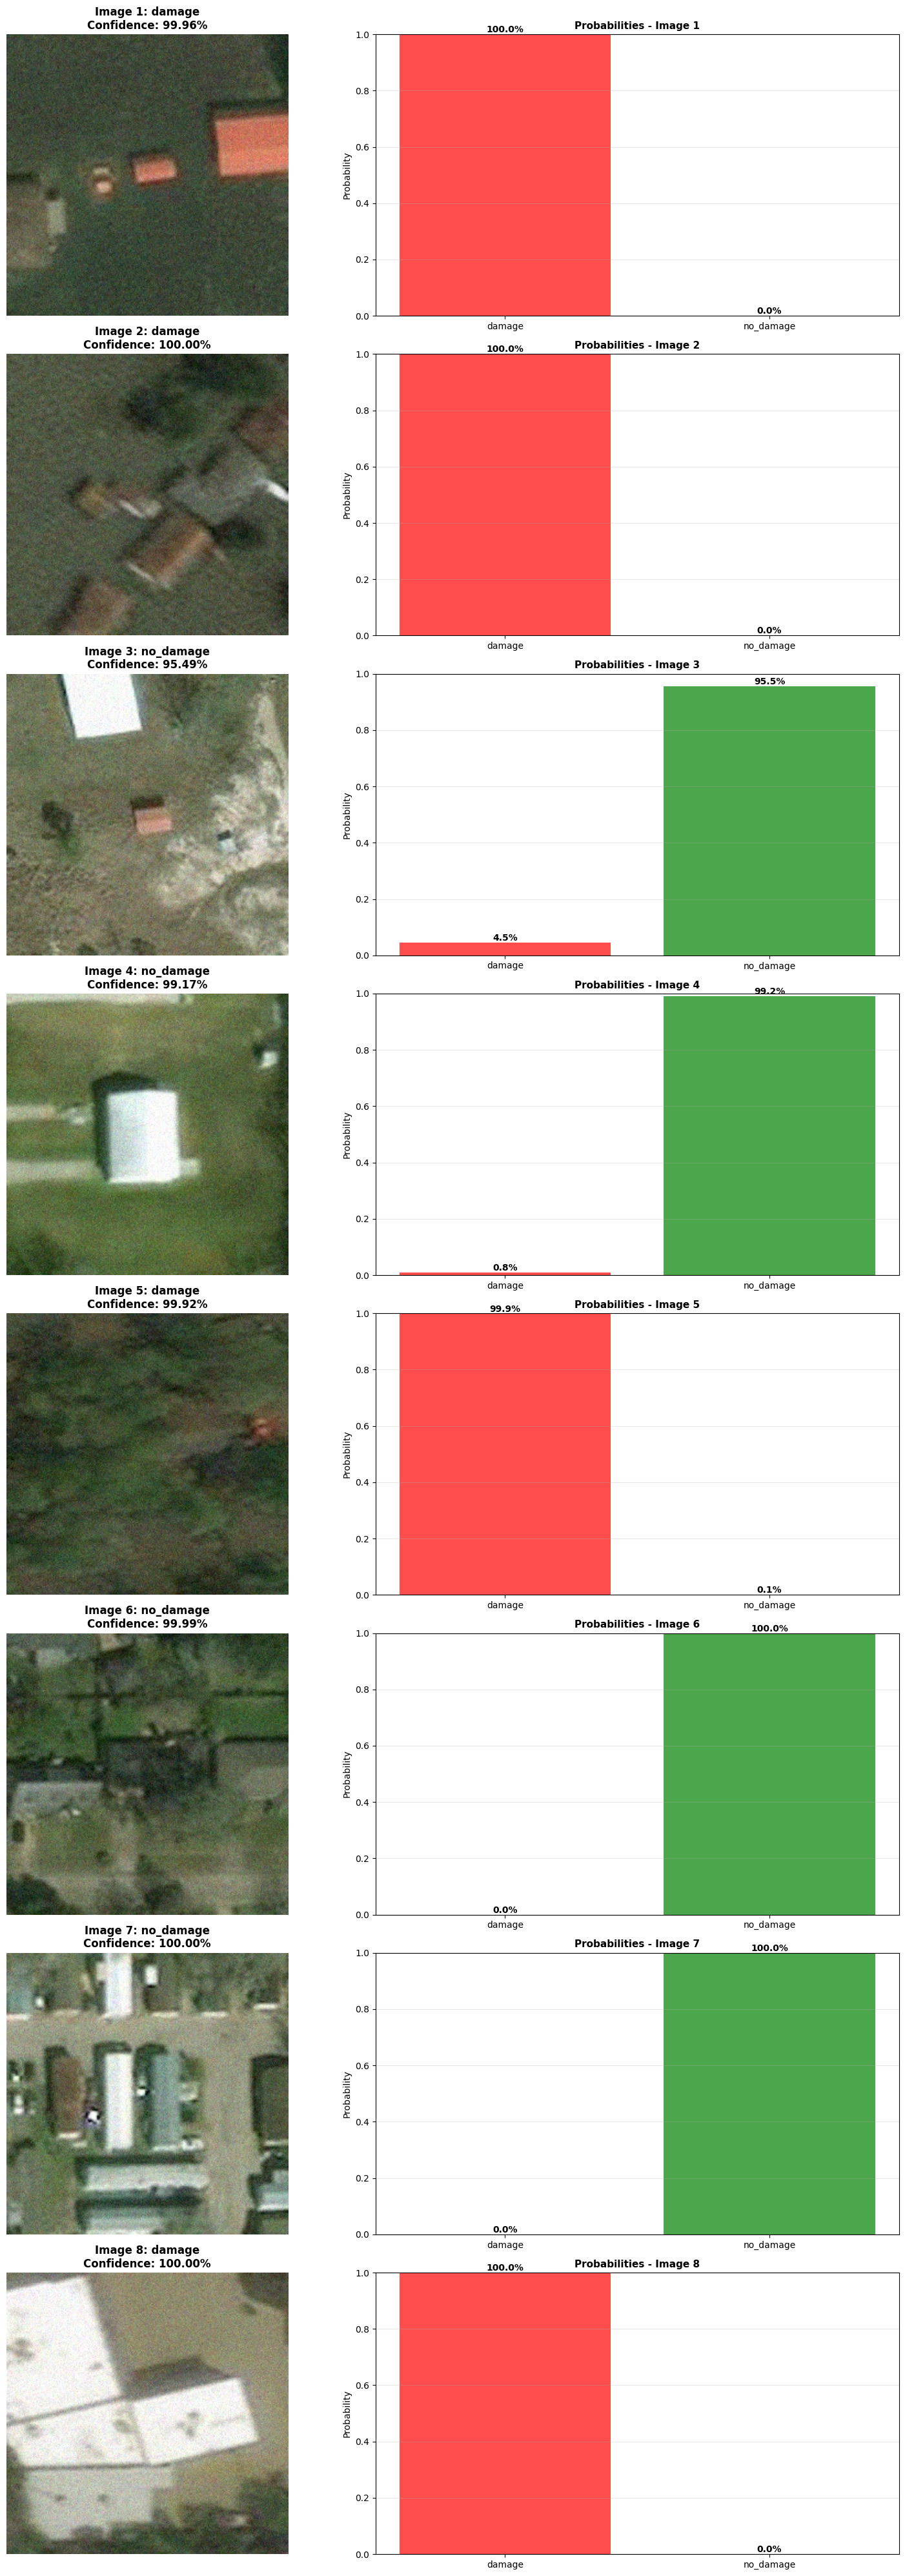

In [38]:
# Create visualization for all images
num_results = len(results)

fig, axes = plt.subplots(num_results, 2, figsize=(16, 5 * num_results))

# Handle case where there's only 1 result
if num_results == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(results):
    # Create subplot for image (left column)
    ax_img = axes[idx, 0]
    ax_img.imshow(result['image'])
    prediction = result['prediction']
    confidence = result['probabilities'][0][prediction].item()
    ax_img.set_title(f"Image {idx+1}: {classes[prediction]}\nConfidence: {confidence*100:.2f}%", 
                     fontsize=12, fontweight='bold')
    ax_img.axis('off')
    
    # Create subplot for probability bar chart (right column)
    ax_bar = axes[idx, 1]
    probs = result['probabilities'][0].cpu().numpy()
    colors_bar = ['red', 'green']
    bars = ax_bar.bar(classes, probs, color=colors_bar, alpha=0.7)
    ax_bar.set_ylabel('Probability', fontsize=10)
    ax_bar.set_title(f'Probabilities - Image {idx+1}', fontsize=11, fontweight='bold')
    ax_bar.set_ylim([0, 1])
    ax_bar.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height,
                    f'{prob*100:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()